In [30]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
pyplot.style.use('ggplot')
from numpy import array

import tensorflow as tf
from tensorflow.python.eager import context
from tensorflow import config

_ = tf.Variable([1])

context._context = None
context._create_context()


config.threading.set_inter_op_parallelism_threads(2)
config.threading.set_intra_op_parallelism_threads(2)

658/658 [==============================] - 0s 732us/step - loss: 0.0399
t+1 RMSE: 0.046258
t+2 RMSE: 0.056782
t+3 RMSE: 0.063717


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f8f7d08fb00>
Traceback (most recent call last):
  File "/home/marina-pk/miniconda3/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 434, in __del__
    context.remove_function(self.name)
  File "/home/marina-pk/miniconda3/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 2237, in remove_function
    context().remove_function(name)
  File "/home/marina-pk/miniconda3/lib/python3.7/site-packages/tensorflow/python/eager/context.py", line 1105, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_standard_lstm_218286'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x7f8f7d08fb00>
Traceback (most recent call last):
  File "/home/marina-pk/miniconda3/lib/python3.7/site-packages/tensorflow/python/eager/function.py",

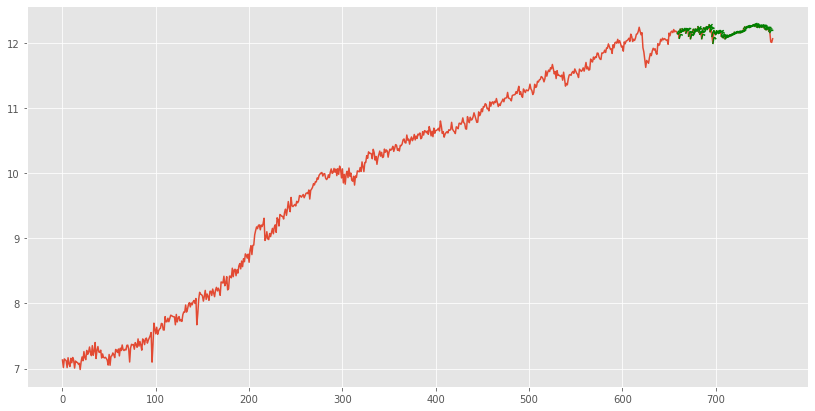

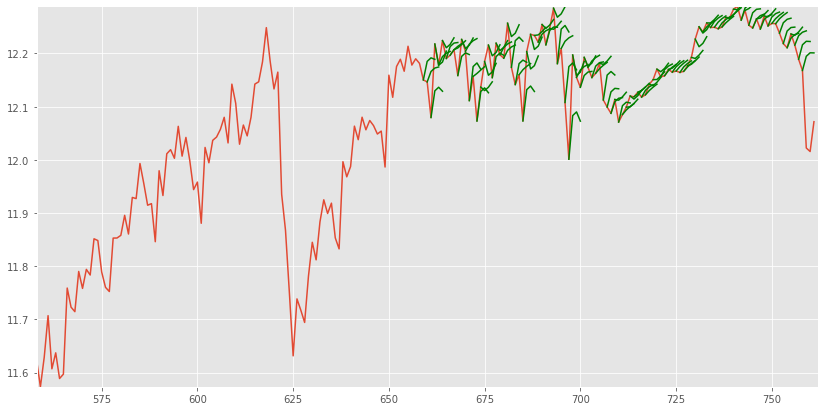

In [35]:


def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    
    
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, shuffle=False)
        model.reset_states()
    return model


def forecast_lstm(model, X, n_batch):
    X = X.reshape(1, 1, len(X))
    forecast = model.predict(X, batch_size=n_batch)
    return [x for x in forecast[0, :]]

def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts


def inverse_difference(last_ob, forecast):
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted


def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        
        inverted.append(inv_diff)
    return inverted

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))

def plot_forecasts(series, forecasts, n_test):
    
    pyplot.figure(figsize=(14,7))
    
    pyplot.plot(series.values)
    
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='green')
        
    pyplot.show()
    
def plot_forecasts_cropped(series, forecasts, n_test):
    
    pyplot.figure(figsize=(14,7))
    
    pyplot.plot(series.values)
    
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i - 1
        off_e = off_s + len(forecasts[i]) + 1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + forecasts[i]
        pyplot.plot(xaxis, yaxis, color='green')
        
    plt.xlim([len(series) - 2*n_test, len(series)])
    plt.ylim(
        [min(series[-2*n_test:]), max(series[-2*n_test:])]
    )
        
    pyplot.show()


n_lag = 1
n_seq = 3
n_test = 100
n_epochs = 100
n_batch = 1
n_neurons = 1

dataframe = pd.read_csv('MBSComtrade.csv')
dataframe['period_in_date'] = pd.to_datetime(dataframe['period_in_date'])
test_c = 'United States'
country_subset = dataframe[dataframe.country_english_name == test_c]

country_import = country_subset[country_subset.trade_flow_desc == 'Imports']
country_export = country_subset[country_subset.trade_flow_desc == 'Exports']


series = country_import.value

for i in series.index:
    series[i] = np.log(series[i])


scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)


actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

evaluate_forecasts(actual, forecasts, n_lag, n_seq)

plot_forecasts(series, forecasts, n_test+2)

plot_forecasts_cropped(series, forecasts, n_test+2)

In [37]:
from scipy.stats import spearmanr

spearmanr(country_export.value, country_import.value)

SpearmanrResult(correlation=0.9957909134760593, pvalue=0.0)